In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

import multiprocessing

print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Sklearn version: {sklearn.__version__}')

Numpy version: 1.18.1
Pandas version: 1.0.3
Sklearn version: 0.22.1


# Setup

In [2]:
# base_dir = r'd:\work\cercetare\2020\quantum_paler\git\k7m\bruteforce'
base_dir = r'/home/local/CORP/lsasu/work/school/quantum_paler/git_k7m/k7m/bruteforce'

In [3]:
n_cores = multiprocessing.cpu_count()

# Read heuristic's results

In [4]:
columns = ['n/a','|','optimal_depth','res_depth','total_time','init_time','nr_t1','nr_t2','|','max_depth','max_children','att_b','att_c','div_dist','cx','depth','trail']

In [5]:
heuristic_hyperparams = ['max_depth', 'max_children', 'att_b', 'att_c', 'div_dist', 'cx']

In [6]:
assert set(heuristic_hyperparams).issubset(set(columns))

In [7]:
files = [file for file in os.listdir(base_dir) if 'training_no_analysis' in file and 'example' not in file]
files = [os.path.join(base_dir, file) for file in files]

In [8]:
def read_file(path, columns=columns):
    df = pd.read_csv(path, sep=',', skiprows=1, header=None)
    df.columns = columns
    df.drop(columns=['|', 'n/a'], axis=1, inplace=True)
    df['ratio_res_opt'] = df.res_depth / df.optimal_depth
    for column_name in df.columns:
        if df[column_name].dtype == 'int64':
            df[column_name] = df[column_name].astype(np.int32)
    return df

In [9]:
dfs = [read_file(file) for file in files]

In [10]:
df_experiments = pd.concat(dfs, axis=0, ignore_index=True)
del dfs

In [11]:
df_experiments.shape

(704079, 15)

In [12]:
df_experiments.head()

,optimal_depth,res_depth,total_time,init_time,nr_t1,nr_t2,max_depth,max_children,att_b,att_c,div_dist,cx,depth,trail,ratio_res_opt
0,5,29,0.042961,0.001817,14,15,13,1,-10,-10,2,2,5,0,5.800000
1,10,51,0.077925,0.002484,14,14,13,1,-10,-10,2,2,10,0,5.100000
2,15,65,0.109975,0.003178,14,10,13,1,-10,-10,2,2,15,0,4.333333
3,20,101,0.152238,0.004190,14,12,13,1,-10,-10,2,2,20,0,5.050000
4,25,127,0.248168,0.004838,13,15,13,1,-10,-10,2,2,25,0,5.080000


In [ ]:
df_experiments.loc[:1000, :]

# Read circuits

In [13]:
circuit_features = ['max_page_rank',  'nr_conn_comp',  'edges',  'nodes',  'efficiency',  'smetric']

In [14]:
circuits_path = os.path.join(base_dir, 'circuits_analysis.csv')
df_circuits = pd.read_csv(circuits_path)
assert set(circuit_features).issubset(set(df_circuits.columns))

In [15]:
df_circuits.shape

(90, 8)

In [16]:
df_circuits.head()

,depth,trail,max_page_rank,nr_conn_comp,edges,nodes,efficiency,smetric
0,5,0,0.029286,7,68,69,0.081875,470.0
1,10,0,0.017183,2,118,105,0.143722,962.0
2,15,0,0.012668,1,169,141,0.141683,1490.0
3,20,0,0.010188,1,219,177,0.141731,1938.0
4,25,0,0.008732,1,268,212,0.126711,2398.0


In [17]:
df_inner_join = pd.merge(df_circuits, df_experiments, how='inner', on=['depth', 'trail'])

# Plot min ratio_res_opt per depth+trail group

## Raw plot

Text(0, 0.5, 'Ratio between results and true optimal value')

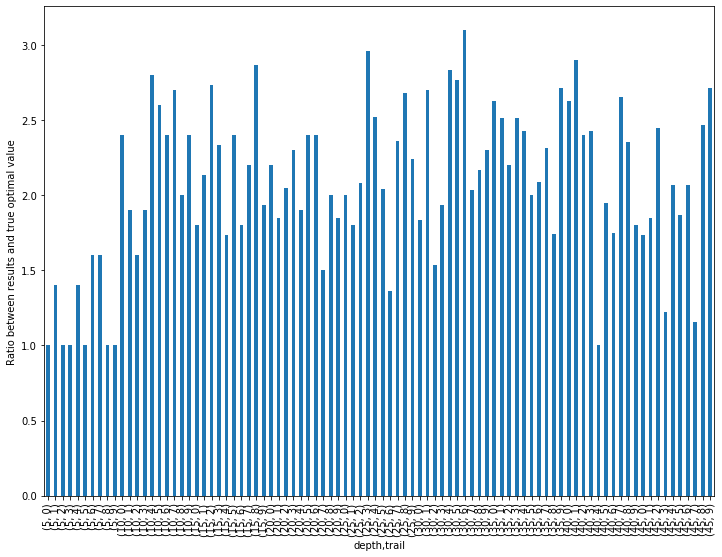

In [23]:
group_depth_trail = df_inner_join.groupby(by=['depth', 'trail'])['ratio_res_opt'].min()
axes = group_depth_trail.plot(kind='bar', figsize=(12, 9))
axes.set_ylabel('Ratio between results and true optimal value')

## Histogram

Text(0.5, 0, 'Ratio between results and true optimal value')

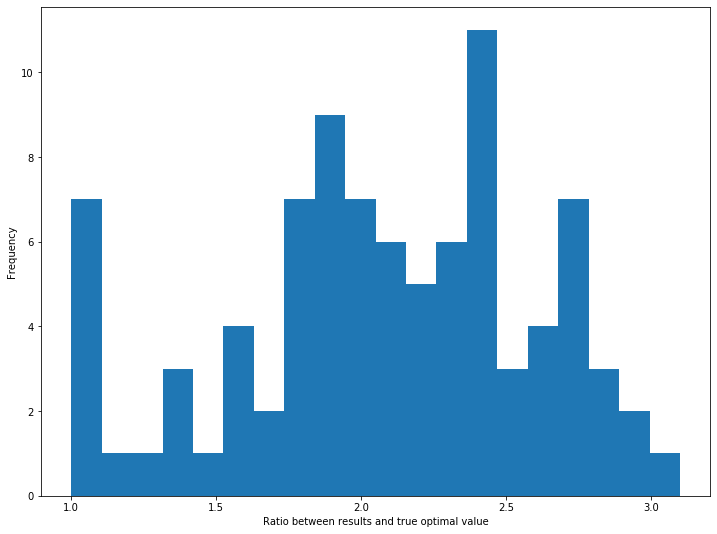

In [19]:
ax_group_histogram = group_depth_trail.plot(kind='hist', figsize=(12, 9), bins=20)
ax_group_histogram.set_xlabel('Ratio between results and true optimal value')

## Order cases by ratio_res_opt

Text(0, 0.5, 'Ratio between results and true optimal value')

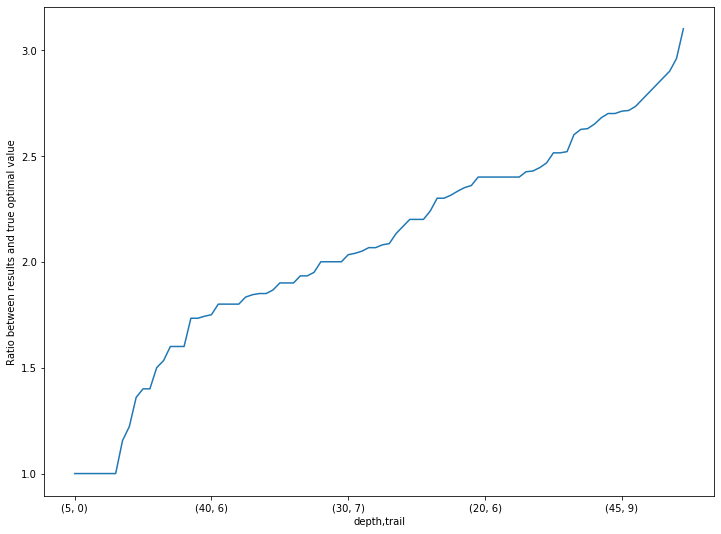

In [20]:
axes_sorted = group_depth_trail.sort_values().plot(figsize=(12, 9))
axes_sorted.set_ylabel('Ratio between results and true optimal value')

In [21]:
# which cases got ratio_res_opt up to a threshold?

threshold_ratio_res_opt = 1.3
series_at_most_threshold = group_depth_trail[group_depth_trail <= threshold_ratio_res_opt]
series_at_most_threshold

depth  trail
5      0        1.000000
       2        1.000000
       3        1.000000
       5        1.000000
       8        1.000000
       9        1.000000
40     4        1.000000
45     3        1.222222
       7        1.155556
Name: ratio_res_opt, dtype: float64

In [22]:
print(f'How many cases with ratio <= {threshold_ratio_res_opt}: {len(series_at_most_threshold)}/{len(group_depth_trail)}')

How many cases with ratio <= 1.3: 9/90


# Data input/output selection

In [23]:
output_features = ['optimal_depth', 'res_depth', 'total_time',
       'init_time', 'nr_t1', 'nr_t2', 'max_depth', 'max_children', 'att_b',
       'att_c', 'div_dist', 'cx', 'ratio_res_opt']

In [24]:
heuristic_hp_names = ['max_depth',  'max_children',  'att_b',  'att_c',  'div_dist',  'cx']
to_predict = ['ratio_res_opt']

# Learn to predict heuristic's output for: (circuit + HPs)

Given a circuit described by circuit_features, and specific values for heurostoc HPs, which is the expected ratio_res_opt?

In [25]:
y = df_inner_join[to_predict].values.ravel()

In [26]:
for_input = circuit_features + heuristic_hp_names
for_input

['max_page_rank',
 'nr_conn_comp',
 'edges',
 'nodes',
 'efficiency',
 'smetric',
 'max_depth',
 'max_children',
 'att_b',
 'att_c',
 'div_dist',
 'cx']

In [27]:
X = df_inner_join[for_input].values
X.shape

(704079, 12)

In [28]:
X.min(axis=0), X.max(axis=0)

# scaling must be done for metric and gradient-based models

(array([ 4.71768034e-03,  1.00000000e+00,  6.80000000e+01,  6.90000000e+01,
         7.15676126e-02,  4.52000000e+02,  1.00000000e+00,  1.00000000e+00,
        -1.00000000e+01, -1.00000000e+01,  2.00000000e+00,  2.00000000e+00]),
 array([3.07452280e-02, 7.00000000e+00, 4.71000000e+02, 3.57000000e+02,
        1.76789985e-01, 4.49200000e+03, 1.70000000e+01, 1.70000000e+01,
        1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01]))

In [29]:
df_onerun=None

In [30]:
def run_model_hardcoded(pipeline, X_train, y_train, X_test, y_test, df):
    pipeline.fit(X_train, y_train)
    y_hat_test = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_hat_test)
    mae = mean_absolute_error(y_test, y_hat_test)
    if df is None:
        df = pd.DataFrame(columns = ['model', 'mse', 'mae', 'model_details'])
    model_name = type(pipeline.steps[-1][-1]).__name__
    row = {'model': model_name, 'mse':mse, 'mae':mae, 'model_details':pipeline.steps[-1][-1]}
    df = df.append(row, ignore_index=True)
    return df

In [31]:
df_CV_simple = None

In [32]:
def run_simple_model_CV(pipeline, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=n_cores-1, verbose=10, df=None):
    scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
    if df is None:
        df = pd.DataFrame(columns = ['model', scoring, 'model_details', 'cv'])
    model_name = type(pipeline.steps[-1][-1]).__name__
    row = {'model': model_name, scoring:np.mean(-scores), 'model_details':pipeline.steps[-1][-1], 'cv':cv}
    df = df.append(row, ignore_index=True)
    return df

In [33]:
df_gridsearch_onesplit = None

In [69]:
def run_gridsearch_onesplit(pipeline, X_train, y_train, X_test, y_test, 
                            param_grid, scoring='neg_mean_squared_error', n_jobs=n_cores-1, 
                            cv=5, verbose=10, df=None):
    clf = GridSearchCV(pipeline, param_grid, scoring=scoring, n_jobs=n_jobs, cv=cv, verbose=verbose)
    clf.fit(X_train, y_train)
    if df is None:
        df = pd.DataFrame(columns = ['model', 'mse', 'mae', scoring, 'best_params', 'model_details', 'cv'])
    y_hat_gs = clf.predict(X_test)
    model_name = type(pipeline.steps[-1][-1]).__name__
    mse = mean_squared_error(y_test, y_hat_gs)
    mae = mean_absolute_error(y_test, y_hat_gs)
    row = {'model': model_name, 
           'mse': mse, 
           'mae': mae,
           scoring: scoring,
           'best_params': clf.best_params_,
           'model_details':pipeline.steps[-1][-1], 
           'cv':cv}
    df = df.append(row, ignore_index=True)
    return df

In [35]:
df_crossvalid_hpsearch = None

In [71]:
def run_crossvalid_hpsearch(X, y, pipeline, param_grid, scoring='neg_mean_squared_error', cv1=5, cv2=5, n_jobs=n_cores-1, df=None):
    scores_cv_gs = cross_val_score(GridSearchCV(estimator = pipeline, param_grid=param_grid, 
                                       scoring='neg_mean_squared_error', cv=k), 
                                       X, y, cv=k, verbose=10, n_jobs=n_cores-1)
    if df is None:
        df = pd.DataFrame(columns = ['model', 'mean_score', scoring, 'model_details', 'cv1', 'cv2'])
    model_name = type(pipeline.steps[-1][-1]).__name__
    mean_score = np.mean(-scores_cv_gs)
    row = {'model': model_name, 
           'mean_score': mean_score, 
           scoring: scoring,
           'cv1': cv1,
           'cv2': cv2,
           'model_details':pipeline.steps[-1][-1]
          }
    df = df.append(row, ignore_index=True)
    return df

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=100)

In [38]:
k = 5

## Model: MLP

In [39]:
pipeline_mlp = Pipeline([('scaler', MinMaxScaler()), ('mlp', MLPRegressor(hidden_layer_sizes=20, activation='relu', max_iter=2000, random_state=100))], verbose=1)

### One train/test split, hardcoded HPs for MLP

In [40]:
df_onerun = run_model_hardcoded(pipeline_mlp, X_train, y_train, X_test, y_test, df_onerun)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing mlp, total=  37.8s


In [41]:
df_onerun

,model,mse,mae,model_details
0,MLPRegressor,0.560168,0.575657,"MLPRegressor(activation='relu', alpha=0.0001, ..."


In [42]:
df_onerun.to_csv('df_onerun.csv', index=False)

### k fold CV, hardcoded HPs for MLP

In [43]:
df_CV_simple = run_simple_model_CV(pipeline_mlp, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=n_cores-1, verbose=10, df=df_CV_simple)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=15)]: Done   3 out of   5 | elapsed:  2.0min remaining:  1.3min
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed:  3.2min finished


In [44]:
df_CV_simple

,model,neg_mean_squared_error,model_details,cv
0,MLPRegressor,2.877248,"MLPRegressor(activation='relu', alpha=0.0001, ...",5


In [45]:
df_CV_simple.to_csv('df_CV_simple.csv', index=False)

### HPs search for MLP

In [78]:
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [100, 50, 20, 10, 3],
}

clf_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp,
                        scoring='neg_mean_squared_error', n_jobs=n_cores-1,
                        cv=k, verbose=10)

In [79]:
df_gridsearch_onesplit = run_gridsearch_onesplit(pipeline_mlp, X_train, y_train, X_test, y_test, 
                                                 param_grid=param_grid_mlp, scoring='neg_mean_squared_error', 
                                                 n_jobs=n_cores-1, cv=k, verbose=10, df=df_gridsearch_onesplit)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  25 | elapsed:  2.7min remaining: 31.4min
[Parallel(n_jobs=15)]: Done   5 out of  25 | elapsed:  3.0min remaining: 12.2min
[Parallel(n_jobs=15)]: Done   8 out of  25 | elapsed:  3.4min remaining:  7.3min
[Parallel(n_jobs=15)]: Done  11 out of  25 | elapsed:  3.6min remaining:  4.6min
[Parallel(n_jobs=15)]: Done  14 out of  25 | elapsed:  4.0min remaining:  3.1min
[Parallel(n_jobs=15)]: Done  17 out of  25 | elapsed:  6.9min remaining:  3.3min
[Parallel(n_jobs=15)]: Done  20 out of  25 | elapsed:  8.1min remaining:  2.0min
[Parallel(n_jobs=15)]: Done  23 out of  25 | elapsed: 10.7min remaining:   55.8s
[Parallel(n_jobs=15)]: Done  25 out of  25 | elapsed: 13.5min finished


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing mlp, total= 9.4min


In [80]:
df_gridsearch_onesplit

,model,mse,mae,neg_mean_squared_error,best_params,model_details,cv
0,KNeighborsRegressor,0.531430,0.571275,neg_mean_squared_error,"{'knn__n_neighbors': 8, 'knn__p': 1}","KNeighborsRegressor(algorithm='auto', leaf_siz...",5
1,RandomForestRegressor,0.349515,0.460214,neg_mean_squared_error,"{'rf__max_depth': None, 'rf__n_estimators': 20}","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",5
2,MLPRegressor,0.456235,0.528674,neg_mean_squared_error,{'mlp__hidden_layer_sizes': 100},"MLPRegressor(activation='relu', alpha=0.0001, ...",5


In [81]:
df_gridsearch_onesplit.to_csv('df_gridsearch_onesplit.csv', index=False)

### Cross validation + nested grid search

In [82]:
df_crossvalid_hpsearch = run_crossvalid_hpsearch(X, y, pipeline_mlp, param_grid_mlp, cv1 = k, cv2 = k, df=df_crossvalid_hpsearch)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of   5 | elapsed: 105.1min remaining: 157.6min
[Parallel(n_jobs=15)]: Done   3 out of   5 | elapsed: 106.8min remaining: 71.2min
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed: 121.1min remaining:    0.0s
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed: 121.1min finished


In [83]:
df_crossvalid_hpsearch

,model,mean_score,neg_mean_squared_error,model_details,cv1,cv2
0,RandomForestRegressor,0.735115,neg_mean_squared_error,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",5,5
1,KNeighborsRegressor,0.765393,neg_mean_squared_error,"KNeighborsRegressor(algorithm='auto', leaf_siz...",5,5
2,MLPRegressor,0.671098,neg_mean_squared_error,"MLPRegressor(activation='relu', alpha=0.0001, ...",5,5


In [84]:
df_crossvalid_hpsearch.to_csv('df_crossvalid_hpsearch.csv', index=False)

## Model: KNN

In [46]:
pipeline_knn = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor(n_neighbors=3))], verbose=1)

### One train/test split, hardcoded HPs for KNN

In [47]:
df_onerun = run_model_hardcoded(pipeline_knn, X_train, y_train, X_test, y_test, df_onerun)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing knn, total=  12.9s


In [48]:
df_onerun

,model,mse,mae,model_details
0,MLPRegressor,0.560168,0.575657,"MLPRegressor(activation='relu', alpha=0.0001, ..."
1,KNeighborsRegressor,0.683094,0.643157,"KNeighborsRegressor(algorithm='auto', leaf_siz..."


In [49]:
df_onerun.to_csv('df_onerun.csv', index=False)

### k fold CV, hardcoded HPs for KNN

In [50]:
df_CV_simple = run_simple_model_CV(pipeline_knn, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=n_cores-1, verbose=10, df=df_CV_simple)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of   5 | elapsed:   37.5s remaining:   56.2s
[Parallel(n_jobs=15)]: Done   3 out of   5 | elapsed:   40.4s remaining:   26.9s
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed:   50.8s remaining:    0.0s
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed:   50.8s finished


In [51]:
df_CV_simple

,model,neg_mean_squared_error,model_details,cv
0,MLPRegressor,2.877248,"MLPRegressor(activation='relu', alpha=0.0001, ...",5
1,KNeighborsRegressor,0.904677,"KNeighborsRegressor(algorithm='auto', leaf_siz...",5


In [52]:
df_CV_simple.to_csv('df_CV_simple.csv', index=False)

### HPs search for KNN

In [53]:
param_grid_knn = {
    'knn__n_neighbors': [4, 5, 6, 7, 8],
    'knn__p': [1, 2],
}

In [54]:
df_gridsearch_onesplit = run_gridsearch_onesplit(pipeline_knn, X_train, y_train, X_test, y_test, 
                                                 param_grid=param_grid_knn, scoring='neg_mean_squared_error', 
                                                 n_jobs=n_cores-1, cv=k, verbose=10, df=df_gridsearch_onesplit)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:   56.9s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  2.0min
[Parallel(n_jobs=15)]: Done  27 out of  50 | elapsed:  2.2min remaining:  1.9min
[Parallel(n_jobs=15)]: Done  33 out of  50 | elapsed:  3.0min remaining:  1.6min
[Parallel(n_jobs=15)]: Done  39 out of  50 | elapsed:  3.4min remaining:   58.3s
[Parallel(n_jobs=15)]: Done  45 out of  50 | elapsed:  3.6min remaining:   24.3s
[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed:  3.9min finished


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing knn, total=  12.9s


In [55]:
df_gridsearch_onesplit

,model,mse,mae,neg_mean_squared_error,best_params,model_details,cv
0,KNeighborsRegressor,0.53143,0.571275,neg_mean_squared_error,"{'knn__n_neighbors': 8, 'knn__p': 1}","KNeighborsRegressor(algorithm='auto', leaf_siz...",5


In [56]:
df_gridsearch_onesplit.to_csv('df_gridsearch_onesplit.csv', index=False)

### Cross validation + nested grid search

In [75]:
df_crossvalid_hpsearch = run_crossvalid_hpsearch(X, y, pipeline_knn, param_grid_knn, cv1 = k, cv2 = k, df=df_crossvalid_hpsearch)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of   5 | elapsed: 24.3min remaining: 36.5min
[Parallel(n_jobs=15)]: Done   3 out of   5 | elapsed: 24.5min remaining: 16.3min
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed: 27.8min remaining:    0.0s
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed: 27.8min finished


In [76]:
df_crossvalid_hpsearch

,model,mean_score,neg_mean_squared_error,model_details,cv1,cv2
0,RandomForestRegressor,0.735115,neg_mean_squared_error,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",5,5
1,KNeighborsRegressor,0.765393,neg_mean_squared_error,"KNeighborsRegressor(algorithm='auto', leaf_siz...",5,5


In [77]:
df_crossvalid_hpsearch.to_csv('df_crossvalid_hpsearch.csv', index=False)

## Random forest

In [57]:
pipeline_rf = Pipeline([('scaler', MinMaxScaler()), ('rf', RandomForestRegressor())], verbose=1)

### One train/test split, hardcoded HPs for RF

In [58]:
df_onerun = run_model_hardcoded(pipeline_rf, X_train, y_train, X_test, y_test, df_onerun)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 2.1min


In [59]:
df_onerun

,model,mse,mae,model_details
0,MLPRegressor,0.560168,0.575657,"MLPRegressor(activation='relu', alpha=0.0001, ..."
1,KNeighborsRegressor,0.683094,0.643157,"KNeighborsRegressor(algorithm='auto', leaf_siz..."
2,RandomForestRegressor,0.338870,0.453411,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio..."


In [60]:
df_onerun.to_csv('df_onerun.csv', index=False)

### k fold CV, hardcoded HPs for RF

In [61]:
df_CV_simple = run_simple_model_CV(pipeline_rf, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=n_cores-1, verbose=10, df=df_CV_simple)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=15)]: Done   3 out of   5 | elapsed:  2.6min remaining:  1.7min
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed:  2.6min finished


In [62]:
df_CV_simple

,model,neg_mean_squared_error,model_details,cv
0,MLPRegressor,2.877248,"MLPRegressor(activation='relu', alpha=0.0001, ...",5
1,KNeighborsRegressor,0.904677,"KNeighborsRegressor(algorithm='auto', leaf_siz...",5
2,RandomForestRegressor,0.976244,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",5


In [63]:
df_CV_simple.to_csv('df_CV_simple.csv', index=False)

### HPs search for RF

In [64]:
param_grid_rf = {
    'rf__max_depth': [1, 2, 3, 4, 5, None],
    'rf__n_estimators': [2, 5, 10, 20]
}

In [65]:
df_gridsearch_onesplit = run_gridsearch_onesplit(pipeline_rf, X_train, y_train, X_test, y_test, 
                                                 param_grid=param_grid_rf, scoring='neg_mean_squared_error', 
                                                 n_jobs=n_cores-1, cv=k, verbose=10, df=df_gridsearch_onesplit)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    3.3s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    3.8s
[Parallel(n_jobs=15)]: Done  31 tasks      | elapsed:    7.8s
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=15)]: Done  55 tasks      | elapsed:   16.7s
[Parallel(n_jobs=15)]: Done  68 tasks      | elapsed:   26.3s
[Parallel(n_jobs=15)]: Done  83 tasks      | elapsed:   33.8s
[Parallel(n_jobs=15)]: Done 104 out of 120 | elapsed:   53.9s remaining:    8.3s
[Parallel(n_jobs=15)]: Done 117 out of 120 | elapsed:  1.4min remaining:    2.1s
[Parallel(n_jobs=15)]: Done 120 out of 120 | elapsed:  1.4min finished


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=  23.8s


In [66]:
df_gridsearch_onesplit

,model,mse,mae,neg_mean_squared_error,best_params,model_details,cv
0,KNeighborsRegressor,0.531430,0.571275,neg_mean_squared_error,"{'knn__n_neighbors': 8, 'knn__p': 1}","KNeighborsRegressor(algorithm='auto', leaf_siz...",5
1,RandomForestRegressor,0.349515,0.460214,neg_mean_squared_error,"{'rf__max_depth': None, 'rf__n_estimators': 20}","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",5


In [67]:
df_gridsearch_onesplit.to_csv('df_gridsearch_onesplit.csv', index=False)

### Cross validation + nested grid search

In [72]:
df_crossvalid_hpsearch = run_crossvalid_hpsearch(X, y, pipeline_rf, param_grid_rf, cv1 = k, cv2 = k, df=df_crossvalid_hpsearch)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of   5 | elapsed:  8.3min remaining: 12.5min
[Parallel(n_jobs=15)]: Done   3 out of   5 | elapsed:  8.6min remaining:  5.7min
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed:  8.7min finished


In [73]:
df_crossvalid_hpsearch

,model,mean_score,neg_mean_squared_error,model_details,cv1,cv2
0,RandomForestRegressor,0.735115,neg_mean_squared_error,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",5,5


In [74]:
df_crossvalid_hpsearch.to_csv('df_crossvalid_hpsearch.csv', index=False)

# Results

In [85]:
df_onerun

,model,mse,mae,model_details
0,MLPRegressor,0.560168,0.575657,"MLPRegressor(activation='relu', alpha=0.0001, ..."
1,KNeighborsRegressor,0.683094,0.643157,"KNeighborsRegressor(algorithm='auto', leaf_siz..."
2,RandomForestRegressor,0.338870,0.453411,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio..."


In [86]:
df_CV_simple

,model,neg_mean_squared_error,model_details,cv
0,MLPRegressor,2.877248,"MLPRegressor(activation='relu', alpha=0.0001, ...",5
1,KNeighborsRegressor,0.904677,"KNeighborsRegressor(algorithm='auto', leaf_siz...",5
2,RandomForestRegressor,0.976244,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",5


In [87]:
df_gridsearch_onesplit

,model,mse,mae,neg_mean_squared_error,best_params,model_details,cv
0,KNeighborsRegressor,0.531430,0.571275,neg_mean_squared_error,"{'knn__n_neighbors': 8, 'knn__p': 1}","KNeighborsRegressor(algorithm='auto', leaf_siz...",5
1,RandomForestRegressor,0.349515,0.460214,neg_mean_squared_error,"{'rf__max_depth': None, 'rf__n_estimators': 20}","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",5
2,MLPRegressor,0.456235,0.528674,neg_mean_squared_error,{'mlp__hidden_layer_sizes': 100},"MLPRegressor(activation='relu', alpha=0.0001, ...",5


In [88]:
df_crossvalid_hpsearch

,model,mean_score,neg_mean_squared_error,model_details,cv1,cv2
0,RandomForestRegressor,0.735115,neg_mean_squared_error,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",5,5
1,KNeighborsRegressor,0.765393,neg_mean_squared_error,"KNeighborsRegressor(algorithm='auto', leaf_siz...",5,5
2,MLPRegressor,0.671098,neg_mean_squared_error,"MLPRegressor(activation='relu', alpha=0.0001, ...",5,5
